In [1]:
import fasttext.util


ft = fasttext.load_model('cc.fa.300.bin')

In [859]:
with open('stopwords.txt',encoding="utf8") as stopwords_file:
    stopwords = stopwords_file.readlines()
stopwords = [line.replace('\n', '') for line in stopwords]

In [860]:
import hazm
stemmer = hazm.Stemmer()
from hazm import word_tokenize
import pandas as pd

In [861]:
data = pd.read_csv('data.csv',names=['question','answer','category'])
data = data.drop(0)
data

,question,answer,category
1,چگونه میتوانم یک پروفایل ایجاد کنم؟,"در وب سایت روی گزینه ""ورود ثبت نام"" کلیک کنید....",ورود و ثبت‌نام
2,چطور میتوانم مشخصات کاربری و ایمیل خود را ویرا...,با وارد کردن ایمیل (یا شماره ی همراه ) وارد حس...,ورود و ثبت‌نام
3,می‏‌توانم سفارشم را تلفنی ثبت کنم؟,خیر، امکان ثبت سفارش بصورت تلفنی امکان پذیر ن...,ورود و ثبت‌نام
4,برای خرید از دیجی‌کالا، حتما باید در سایت عضو ...,بله. قبل از خرید میبایست از طریق شماره موبایل ...,ورود و ثبت‌نام
5,من دو حساب کاربری در دیجی‌کالا دارم، آیا می‌تو...,بله، شما می‌توانید حساب‌های کاربری خود را در د...,ورود و ثبت‌نام
...,...,...,...
62,اگر در بازه زمانی انتخابی، در محل برای دریافت ...,در صورت امکان هماهنگی لازم جهت ارسال مجدد صورت...,سوپرمارکت
63,چطور میتوانم سفارش کالای سوپر مارکتی خود را پس...,مرجوع نمودن سلیقه ای اقلام سوپرمارکتی بعد از ت...,سوپرمارکت
64,چطور میتوانم سفارش سوپرمارکتی خود را لغو کنم ؟,"شما میتوانید تا پیش از مرحله ""دریافت در مرکز ت...",سوپرمارکت
65,چطور میتوانم سفارش سوپرمارکتی خود را ویرایش کنم؟,"شما میتوانید تا پیش از مرحله ""آماده سازی سفارش...",سوپرمارکت


In [862]:
lem = hazm.Lemmatizer()
dataset = pd.DataFrame(columns=('question','answer', 'category'))
for index, row in data.iterrows():
    title_body = row['question']
    title_body_tokenized = word_tokenize(title_body)
    title_body_tokenized_filtered = [w for w in title_body_tokenized if not w in stopwords]
    title_body_tokenized_filtered_stemmed = [stemmer.stem(w) for w in title_body_tokenized_filtered]
    title_body_tokenized_filtered_lem = [lem.lemmatize(w).replace('#', ' ') for w in title_body_tokenized_filtered]
    dataset.loc[index] = {
        'question':  ' ' .join(title_body_tokenized_filtered_lem),
        'category': row['category'].replace('\n', ''),
        'answer': row['answer'].replace('\n', '')
    }

In [865]:
from transformers import BertModel, BertTokenizer
model = BertModel.from_pretrained("bert-base-cased").to(device)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [866]:
def embed_bert(prompt):
    encoded_input = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True).to(device)
    X = model(**encoded_input)
    return X.last_hidden_state[:, 0, :]

In [867]:
embedding_bert_df = pd.DataFrame(index=dataset.index, columns = range(768))
for i in range(len(dataset)):
    embedding_bert_df.loc[dataset.index[i], :] = embed_bert(dataset.question.values[i]).cpu().detach()

In [868]:
def embed_fastxt(prompt):
    return ft.get_sentence_vector(prompt)

    
    


In [869]:
embedding_df = pd.DataFrame(index=dataset.index, columns = range(300))
for i in range(len(dataset)):
    embedding_df.loc[dataset.index[i], :] = embed_fastxt(dataset.question.values[i])

In [870]:
from sklearn.feature_extraction.text import CountVectorizer
def bag_of_words_df(data):
    vectorizer = CountVectorizer()
    vectorizer.fit(data)

    embedding_bag = vectorizer.transform(data)

    embedding_bag_df = pd.DataFrame(embedding_bag.toarray(), columns=vectorizer.get_feature_names_out())
    return embedding_bag_df

In [871]:
from gensim.models import Word2Vec

def word_2_vec_model_cerate(X):
    se = data['question']
    sentences = [word_tokenize(sentence) for sentence in X]
    w2v_model = Word2Vec(sentences, window=5, min_count=5, workers=4)
    return w2v_model

def word2_vec_embeded(w2v_model,sentence):
    words = word_tokenize(sentence)
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X = dataset['question'].values
w2v_model = word_2_vec_model_cerate(X)
embedding_word2vec_df = pd.DataFrame(index=dataset.index, columns = range(100))
for i in range(len(dataset)):
    embedding_word2vec_df.loc[dataset.index[i], :] = word2_vec_embeded(w2v_model,dataset.question.values[i])

In [872]:
with open('wrod_meaning.json', 'r', encoding='utf-8') as file:
    meanings = json.load(file)
    

In [873]:
def find_text_similarity_fasstext(sentence,typo):
    title_body = sentence
    title_body_tokenized = word_tokenize(title_body)
    title_body_tokenized_filtered = [w for w in title_body_tokenized if not w in stopwords]
    title_body_tokenized_filtered_stemmed = [stemmer.stem(w) for w in title_body_tokenized_filtered]
    title_body_tokenized_filtered_lem = [lem.lemmatize(w).replace('#', ' ') for w in title_body_tokenized_filtered]
    w=' '.join(title_body_tokenized_filtered_stemmed)
    if typo == "fasstext":   
        embedding_s = embed_fastxt(w)
        embeddings_array = embedding_df.to_numpy()
        embedding_s = embedding_s.reshape(1, -1)
    if typo == "w2v":
        embedding_s = word2_vec_embeded(w2v_model,w)
        embeddings_array = embedding_word2vec_df.to_numpy()
        embedding_s = embedding_s.reshape(1, -1)
    if typo == "bert":
        embedding_s = embed_bert(w)
        embeddings_array = embedding_bert_df.to_numpy()
        embedding_s = embedding_s.cpu().detach()
        embedding_s = embedding_s.reshape(1, -1)

        
    cos_sim_scores = cosine_similarity(embedding_s , embeddings_array)
    most_similar_index = np.argmax(cos_sim_scores)
    most_similar_row = dataset.iloc[most_similar_index]
    return most_similar_row['answer']


In [874]:
tested_question_answer = {'question':[],'answer_bert':[],'answer_fasstext':[] , 'asnwer_w2vec':[]}

In [875]:
tested_df = pd.read_csv('tested.csv')

In [876]:
tested_df.head(10)

,tested_question
0,شماره کارتمو چجوری وارد کنم
1,چگونه میشه خرید رو مرجوع کرد
2,چطور به حسابم پول بریزم
3,چطوری تلفنی باید سفارش بدم
4,پیگیری سفارش به چه صورت است
5,فعال کردن گارانتی به چه صورت است
6,چگونه خریدم را لغو کنم
7,هزینه ارسال سفارش با فروشنده چقدر است
8,میخوام سفارش سوپرمارکتی رو لغو کنم باید چیکار کنم


In [882]:
tested_df = pd.read_csv('tested.csv')
for sens in test_sens:
    tested_question_answer['question'].append(sens)
    x=find_text_similarity_fasstext(sens,'bert')
    tested_question_answer['answer_bert'].append(x)
    y=find_text_similarity_fasstext(sens,'fasstext')
    tested_question_answer['answer_fasstext'].append(y)
    z=find_text_similarity_fasstext(sens,'w2v')
    tested_question_answer['asnwer_w2vec'].append(z)

In [878]:
for sens in test_sens:
    tested_question_answer['question'].append(sens)
    x=find_text_similarity_fasstext(sens,'bert')
    tested_question_answer['answer_bert'].append(x)
    y=find_text_similarity_fasstext(sens,'fasstext')
    tested_question_answer['answer_fasstext'].append(y)
    z=find_text_similarity_fasstext(sens,'w2v')
    tested_question_answer['asnwer_w2vec'].append(z)

In [879]:
def meaning_function(word, top_k=10):
    similar_words = meanings[word]
    return similar_words[0][1],similar_words[1][1]

In [880]:
import itertools
import random
def generate_sentences(sentence):
    words = word_tokenize(sentence)
    word_meanings = []
    word_meanings_2  = []
    sentences = []

    # Get the meanings for each word
    for word in words:
        word_meanings.append(meaning_function(word)[0])
        word_meanings_2.append(meaning_function(word)[1])
    
    for i in range(100):
        word_sens = []
        for j in range(len(words)):
            x=random.uniform(0, 1)
            if x<=0.33:
                word_sens.append(words[j])
            elif x>0.33 and x<=0.66:
                word_sens.append(word_meanings[j])
            else:
                word_sens.append(word_meanings_2[j])
        final_s = ' '.join(word_sens)
        sentences.append(final_s)    
        

    return sentences

In [661]:
setences = dataset['question'].values
response = dataset['answer'].values
cat = dataset['category'].values

نیاز با اجرای دو سلول پایین نمی باشد زیرا صرفا برای افزایش دیتا می باشند

In [663]:
final_dict = {'question':[],'answer':[],'category':[]}

In [ ]:
for q in range(len(setences)):
    final_dict['question'].append(setences[q])
    final_dict['answer'].append(response[q])
    final_dict['category'].append(cat[q])
    generation = generate_sentences(setences[q])
    for g in generation:
        final_dict['question'].append(g)
        final_dict['answer'].append(response[q])
        final_dict['category'].append(cat[q])

In [881]:
tested_df = pd.read_csv('tested.csv')
for sens in test_sens:
    tested_question_answer['question'].append(sens)
    x=find_text_similarity_fasstext(sens,'bert')
    tested_question_answer['answer_bert'].append(x)
    y=find_text_similarity_fasstext(sens,'fasstext')
    tested_question_answer['answer_fasstext'].append(y)
    z=find_text_similarity_fasstext(sens,'w2v')
    tested_question_answer['asnwer_w2vec'].append(z)

In [883]:
f = pd.read_csv('file1.csv')
f.head(101)
f = f.drop(df.index[:100])
f.head()

,Unnamed: 0,question,answer,category
100,100,میتوان پروفایلی ایجاد,"در وب سایت روی گزینه ""ورود ثبت نام"" کلیک کنید....",ورود و ثبت‌نام
101,101,نمیتوان پروفایلی ایجادد,"در وب سایت روی گزینه ""ورود ثبت نام"" کلیک کنید....",ورود و ثبت‌نام
102,102,نمیتوان پروفایلپروفایل ايجاد,"در وب سایت روی گزینه ""ورود ثبت نام"" کلیک کنید....",ورود و ثبت‌نام
103,103,ميتوان پروفایل ایجادد,"در وب سایت روی گزینه ""ورود ثبت نام"" کلیک کنید....",ورود و ثبت‌نام
104,104,نمیتوان پروفایلی ايجاد,"در وب سایت روی گزینه ""ورود ثبت نام"" کلیک کنید....",ورود و ثبت‌نام


In [884]:
dataset_t = f

In [885]:
embedding_df_train = pd.DataFrame(index=dataset_t.index, columns = range(300))
for i in range(len(dataset_train)):
    embedding_df_train.loc[dataset_t.index[i], :] = embed_fastxt(dataset_t.question.values[i])

In [886]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(dataset_t['answer'])

In [889]:
y

array([34, 34, 34, ..., 18, 18, 18])

In [887]:
tags = list(set(dataset_t['answer'].values))
len(tags)

61

In [890]:
X = embedding_df_train.to_numpy()

In [891]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek()
X_smt, y_smt = smt.fit_resample(X, y)

In [901]:
X_smt

array([[ 0.06861567,  0.10363948, -0.02615903, ..., -0.01695884,
        -0.016668  , -0.0194851 ],
       [ 0.04514549,  0.07899803, -0.01036287, ..., -0.01626684,
         0.00957104, -0.03043484],
       [ 0.07237871,  0.07170174, -0.00716843, ...,  0.02033482,
         0.0130104 , -0.01537217],
       ...,
       [ 0.06718965,  0.10277224, -0.04773954, ..., -0.00105892,
         0.01287783, -0.02092995],
       [ 0.08616668,  0.09647687, -0.0686719 , ..., -0.00260486,
         0.01427623, -0.01297266],
       [ 0.07742275,  0.09868739, -0.06433915, ..., -0.02200346,
         0.01355314, -0.03006593]])

In [902]:
X,y = X_smt, y_smt

In [903]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)

In [904]:
y_train.dtype

dtype('int32')

In [905]:
X_train = np.array(X_train,dtype = np.float32)

(array([1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200., 1200.,
        1400.]),
 array([ 0.,  6., 12., 18., 24., 30., 36., 42., 48., 54., 60.]),
 <BarContainer object of 10 artists>)

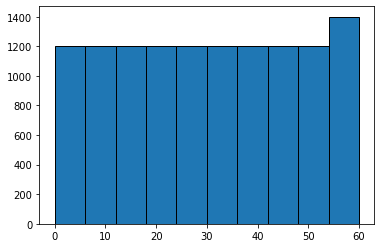

In [906]:
import matplotlib.pyplot as plt
plt.hist(y, bins=10, edgecolor='black')

In [907]:
import numpy as np
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
class ChatDataset(Dataset):

    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = y_train
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples

In [908]:
import torch
import torch.nn as nn


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        return out

In [909]:
num_epochs = 200
batch_size = 100
learning_rate = 0.001
input_size =  len(X_train[0])
hidden_size = 128
output_size = len(tags)
dataset_chat = ChatDataset()
print(input_size,output_size)

train_loader = DataLoader(dataset=dataset_chat,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

300 61


In [910]:
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        outputs = model(words)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    if (epoch+1) % 2 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.10f}')

Epoch [2/200], Loss: 0.6367280483
Epoch [4/200], Loss: 0.0551602989
Epoch [6/200], Loss: 0.0123455338
Epoch [8/200], Loss: 0.0078144381
Epoch [10/200], Loss: 0.0041120476
Epoch [12/200], Loss: 0.0026954210
Epoch [14/200], Loss: 0.0021269999
Epoch [16/200], Loss: 0.0014219830
Epoch [18/200], Loss: 0.0011206240
Epoch [20/200], Loss: 0.0007176073
Epoch [22/200], Loss: 0.0004787581
Epoch [24/200], Loss: 0.0005571804
Epoch [26/200], Loss: 0.0003788203
Epoch [28/200], Loss: 0.0002887622
Epoch [30/200], Loss: 0.0003263674
Epoch [32/200], Loss: 0.0001332481
Epoch [34/200], Loss: 0.0002045576
Epoch [36/200], Loss: 0.0001677503
Epoch [38/200], Loss: 0.0001549833
Epoch [40/200], Loss: 0.0001139997
Epoch [42/200], Loss: 0.0001059062
Epoch [44/200], Loss: 0.0000921896
Epoch [46/200], Loss: 0.0000755167
Epoch [48/200], Loss: 0.0000579805
Epoch [50/200], Loss: 0.0000593753
Epoch [52/200], Loss: 0.0000573555
Epoch [54/200], Loss: 0.0000454878
Epoch [56/200], Loss: 0.0000539381
Epoch [58/200], Loss: 0.

In [843]:
X_test = np.array(X_test,dtype = np.float32)

In [845]:
words = torch.from_numpy(X_test)
labels = torch.from_numpy(y_test).to(dtype=torch.long)
outputs = model(words)

loss = criterion(outputs, labels)
loss

tensor(3.0474e-06, grad_fn=<NllLossBackward0>)

In [846]:
data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"tags": tags
}

In [847]:
FILE = "data_final.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')

training complete. file saved to data_final.pth


In [850]:
def res(w):
    FILE = "data_final.pth"
    data = torch.load(FILE)

    input_size = data["input_size"]
    hidden_size = data["hidden_size"]
    output_size = data["output_size"]
    tags = data['tags']
    model_state = data["model_state"]

    model = NeuralNet(input_size, hidden_size, output_size).to(device)
    model.load_state_dict(model_state)
    model.eval()
    title_body = w
    title_body_tokenized = word_tokenize(title_body)

    title_body_tokenized_filtered = [w for w in title_body_tokenized if not w in stopwords]
    title_body_tokenized_filtered_stemmed = [stemmer.stem(w) for w in title_body_tokenized_filtered]
    title_body_tokenized_filtered_lem = [lem.lemmatize(w).replace('#', ' ') for w in title_body_tokenized_filtered]
    w=' '.join(title_body_tokenized_filtered_stemmed)
    X = embed_fastxt(sentence)
    X = torch.from_numpy(X).to(device)
    X = X.reshape(1, X.shape[0])
    output = model(X)
    _, predicted= torch.max(output, dim=1)
    inde = predicted.item()
    return tags[inde]
    
    

In [911]:

def Response(question):
    y=find_text_similarity_fasstext(question,'fasstext')
    return y
    

In [912]:
Response('چگونه خریدم را لغو کنم')

'شما میتوانید تا پیش از مرحله "دریافت در مرکز توزیع"، ازطریق صفحه  سفارش های من و یا تماس تلفنی سفارش خود را لغو نمایید. لطفا در صورت نیاز به تماس تلفنی، شماره سفارش خود را قبل از تماس آماده نمایید.'